In [1]:
%pip install opencv-python matplotlib numpy scikit-learn --quiet
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ----- 1. Data preparation -----

def extractFrames(video_path, output_path, max_frame_count):
    """ 
    Extracts frames (images) from a video at `video_path` and writes them to `output_path`
    Stops extracting at `max_frame_count` if specified.
    """
    
    video = cv2.VideoCapture(video_path)
    success, img = video.read()

    count = 0
    while success and count < max_frame_count:
        count += 1
        cv2.imwrite(f"{output_path}/frame{count}.jpg", img)
        success, img = video.read()

    print(f"Extracted {count} frames!")

def wipeFolder(folder_path):
    """
    Removes all files in a folder. 
    Intended to be used to delete all frames extracted.
    """
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        os.remove(file_path)

VIDEOS_DIR_PATH = "videos/trimmed/"
FRAMES_DIR_PATH = "frames/"
TEST_VIDEO = "clair_de_lune.mp4"

# wipeFolder(FRAMES_DIR_PATH) # Use this to wipe "frames" folder
extractFrames(VIDEOS_DIR_PATH + TEST_VIDEO, FRAMES_DIR_PATH, 10)

Extracted 10 frames!


(np.float64(-0.5), np.float64(191.5), np.float64(107.5), np.float64(-0.5))

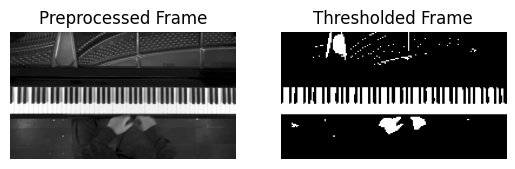

In [3]:
# ----- 2. Frame Preprocessing -----

def preProcessFrame(frame_path, kernel_size=(5, 5)):
    """
    Preprocesses a frame at `frame_path`, through the following steps:
        1. Convert to grayscale
        2. Blur with box filter, with `kernel_size`
    Returns the frame.
    """
    # Load frame
    frame = cv2.imread(frame_path)
    if frame is None:
        print("Failed to read frame.")
        return

    # Convert to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Blur
    frame_blur = cv2.blur(frame_gray, kernel_size)

    return frame_blur

def downsizeBinarizeFrame(frame, downsize_factor=10, binary_threshold=100):
    """
    Further preprocess a frame as follows:
        1. Downsize by `downsize_factor`
        2. Binarize. Pixels above `binary_threshold` is set to white (255), otherwise black (0).
    Returns the frame.
    """
    # Downsize
    new_width, new_height = frame.shape[1] // 10, frame.shape[0] // 10
    frame_small = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Binarize
    _, frame_binary = cv2.threshold(frame_small, binary_threshold, 255, cv2.THRESH_BINARY)

    return frame_binary


TEST_FRAME = "frame3.jpg"
frame_preprocessed = preProcessFrame(FRAMES_DIR_PATH + TEST_FRAME)
frame_thresholded = downsizeBinarizeFrame(frame_preprocessed, binary_threshold=75)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(frame_preprocessed, cmap="gray")
plt.title("Preprocessed Frame")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(frame_thresholded, cmap="gray")
plt.title("Thresholded Frame")
plt.axis("off")

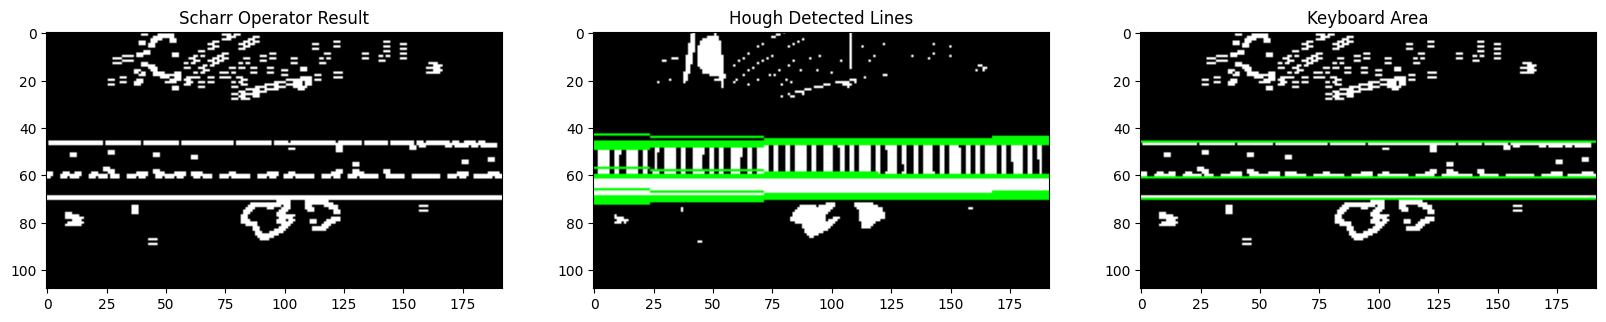

In [4]:
# ----- 3. Keyboard Area Detection -----

# Scharr Operator implementation
HORIZ_SCHARR_KERNEL = np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]])
VERT_SCHARR_KERNEL = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])

def applyScharr(img, is_horiz):
    """
    Applies the Scharr operator to a grayscale `img` to find edges in one direction.
    Finds horizontal edges if `is_horiz` is set to True, otherwise vertical edges.
    """
    kernel = HORIZ_SCHARR_KERNEL if is_horiz else VERT_SCHARR_KERNEL
    result = cv2.convertScaleAbs(cv2.filter2D(img, cv2.CV_64F, kernel))

    return result

# Hough Transform implementation
def findHoughLines(img_edges, threshold=100, theta_min=-np.pi/2, theta_max=np.pi/2, theta_step=np.pi/180, rho_step=1, 
                   use_nms=True, nms_window_size=3):
    # Initialize Hough space
    diag_length = np.sqrt(img_edges.shape[0] ** 2 + img_edges.shape[1] ** 2)
    rho_values = np.arange(-diag_length, diag_length, rho_step)
    theta_values = np.arange(theta_min, theta_max, theta_step)
    cos_values = np.cos(theta_values)
    sin_values = np.sin(theta_values)

    hough_space = np.zeros((len(rho_values), len(theta_values)))

    # Search Hough space by iterating over all edge pixels
    for height, width in zip(*np.where(img_edges > 0)):
        for theta_idx in range(len(theta_values)):
            rho = width * cos_values[theta_idx] + height * sin_values[theta_idx]
            closest_valid_rho_idx = np.argmin(abs(rho - rho_values))
            hough_space[closest_valid_rho_idx, theta_idx] += 1
    
    # Apply non-maximum suppression
    if use_nms:
        pad = nms_window_size // 2
        rows, cols = hough_space.shape
        for row in range(pad, rows - pad):
            for col in range(pad, cols - pad):
                window = hough_space[row - pad: row + pad + 1, col - pad: col + pad + 1]

                # Suppress vote if not maximum in window
                if hough_space[row, col] != np.max(window):
                    hough_space[row, col] = 0

    # Get polar coordinates of found lines
    rho_indices, theta_indices = np.where(hough_space > threshold)
    found_rho_values = rho_values[rho_indices]
    found_sin_values = sin_values[theta_indices]
    found_cos_values = cos_values[theta_indices]

    # Convert back to Cartesian coordinates and draw lines
    lines = []
    for rho, sin, cos in zip(found_rho_values, found_sin_values, found_cos_values):
        x0, y0 = rho * cos, rho * sin
        x1 = int(x0 + 1000 * -sin)
        y1 = int(y0 + 1000 * cos)
        x2 = int(x0 - 1000 * -sin)
        y2 = int(y0 - 1000 * cos)
        lines.append((x1, y1, x2, y2))

    return lines

# Average lines by groups
def averageLines(lines, img, num_groups=3):
    # Sort lines by descending height
    lines_sorted = sorted(lines, key=lambda line: np.mean([line[1], line[3]]))

    # Group lines by y-coordinate
    line_groups = {}
    for line in lines_sorted:
        x1, y1, x2, y2 = line
        y_avg = np.mean([y1, y2])
        
        added = False
        for group in line_groups:
            if abs(y_avg - group) < 10: # 10 pixels in proximity
                line_groups[group].append(y_avg)
                added = True
                break
        if not added:
           line_groups[y_avg] = [y_avg]
    
    # Average lines
    result = []
    for line_heights in line_groups.values():
        y_avg = int(np.mean(line_heights))
        result.append((0, y_avg, img.shape[1], y_avg)) 
    
    return result

# Rotate frame if potentially upside down
def rotateFrameMaybe(frame, defining_lines):
    top, middle, bottom = defining_lines
    middle_y = middle[1]
    
    # Extract pixels above and below the middle line
    upper_region = frame[:middle_y, :]
    lower_region = frame[middle_y:, :]

    # Count black key pixels
    upper_black_count = np.sum(upper_region == 0)
    lower_black_count = np.sum(lower_region == 0)
    
    # Rotate if black keys are in lower region
    if lower_black_count > upper_black_count:
        frame = cv2.rotate(frame, cv2.ROTATE_180)

        height = frame.shape[0]
        top = (top[0], height - top[1])
        middle = (middle[0], height - middle[1])
        bottom = (bottom[0], height - bottom[1])

    return frame, [top, middle, bottom]

frame_scharr = applyScharr(frame_thresholded, True)
hough_lines = findHoughLines(frame_scharr)
defining_lines = averageLines(hough_lines, frame_scharr)

frame_keyboard_area_final, defining_lines = rotateFrameMaybe(frame_scharr, defining_lines)

# Scharr result
plt.figure(figsize=(20, 12))
plt.subplot(1, 3, 1)
plt.imshow(frame_scharr, cmap="gray")
plt.title("Scharr Operator Result")

# Hough Lines result
img_copy_1 = cv2.cvtColor(frame_thresholded, cv2.COLOR_GRAY2BGR)
for x1, y1, x2, y2 in hough_lines:
    cv2.line(img_copy_1, (x1, y1), (x2, y2), (0, 255, 0), thickness=1)
plt.subplot(1, 3, 2)
plt.imshow(img_copy_1)
plt.title("Hough Detected Lines")

# Final keyboard area result
img_copy_2 = cv2.cvtColor(frame_keyboard_area_final, cv2.COLOR_GRAY2BGR)
for x1, y1, x2, y2 in defining_lines:
    cv2.line(img_copy_2, (x1, y1), (x2, y2), (0, 255, 0), thickness=1)
plt.subplot(1, 3, 3)
plt.imshow(img_copy_2)
plt.title("Keyboard Area")
plt.show()

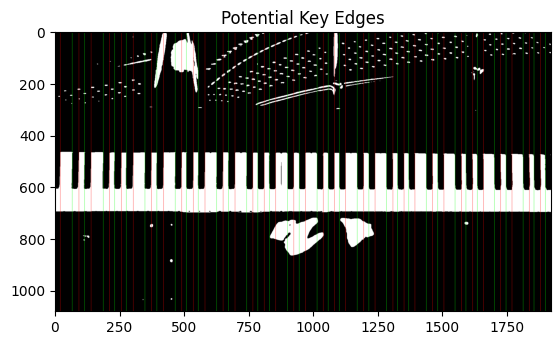

In [5]:
# ----- 4. Keys Detection -----
def detectKeyEdges(frame, defining_lines, region_height_ratio=0.5):
    height, width = frame.shape
    top, middle, bottom = defining_lines
    top_y, middle_y, bottom_y = top[1], middle[1], bottom[1]
    
    # Get a region of keyboard to detect keys from
    region_height = int((middle_y - top_y) * region_height_ratio)
    region_bottom_y = top_y + region_height
    region = frame[top_y:region_bottom_y, :]
    
    # Traverse line parallel
    line_y = top_y + region_height // 2
    line = region[line_y - top_y, :]

    # Detect transitions between black and white keys
    key_edges = []
    prev = None
    for idx in range(1, len(line)):
        if prev is not None and line[idx] != prev:
            color = 1 if prev else 0
            key_edges.append((idx, color))
        prev = line[idx]

    return key_edges

# Use full-sized, grayscale frame
binary_threshold = 80
_, frame_binarized = cv2.threshold(frame_preprocessed, binary_threshold, 255, cv2.THRESH_BINARY)

# Scale up defining lines. Get potential edges
upscale_defining_lines = [(x1, y1 * 10, x2, y2 * 10) for x1, y1, x2, y2 in defining_lines]
potential_edges = detectKeyEdges(frame_binarized, upscale_defining_lines)

# Visualize
frame_copy = cv2.cvtColor(frame_binarized, cv2.COLOR_GRAY2BGR)
for edge, is_white_to_black in potential_edges:
    color = (0, 255, 0) if is_white_to_black else (255, 0, 0)
    cv2.line(frame_copy, (edge, 0), (edge, frame_copy.shape[1]), color, thickness=1)
plt.figure()
plt.imshow(frame_copy)
plt.title("Potential Key Edges")
plt.show()

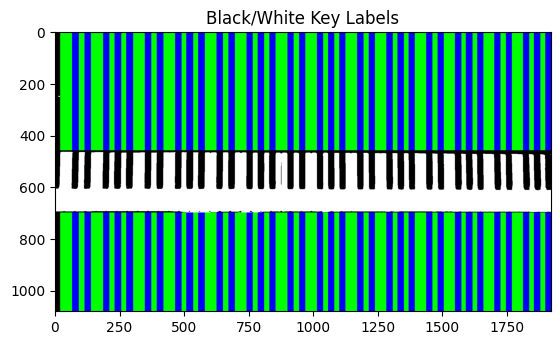

In [6]:
# Label each key as black (B), white (W), or consecutive whites (WW)
def labelKeys(edges):
    # Find true width between each pair of edges
    widths = [edges[i][0] - edges[i - 1][0] for i in range(1, len(edges))]
    rounded_widths = [round(w, -1) for w in widths] # Round to nearest 10 pixel
    true_width = Counter(rounded_widths).most_common(1)[0][0]
    
    # Label keys as black/white
    keys = []
    tolerance = 0.5 * true_width
    for i in range(1, len(edges)):
        width = edges[i][0] - edges[i - 1][0]
        color = edges[i][1]

        if abs(width - true_width) < tolerance:
            label = "W" if color else "B"
            keys.append((label, edges[i - 1], edges[i]))
        elif abs(width - 2 * true_width) < tolerance:
            keys.append(("WW", edges[i - 1], edges[i]))

    return keys

# Visualize result
frame_copy = cv2.cvtColor(frame_binarized, cv2.COLOR_GRAY2BGR)

keys = labelKeys(potential_edges)
top, _, bottom = upscale_defining_lines
for key in keys:
    label, left_edge, right_edge = key
    fill_color = (0, 255, 0) if "W" in label else (0, 0, 255)

    frame_copy[0:top[1], left_edge[0]:right_edge[0]] = fill_color
    frame_copy[bottom[1]:, left_edge[0]:right_edge[0]] = fill_color
    
plt.figure()
plt.imshow(frame_copy)
plt.title("Black/White Key Labels")
plt.show()


In [7]:
# Deal with consecutive white keys
def interpolateWhiteKeys(keys):
    real_keys = []
    for key in keys:
        label, left_edge, right_edge = key

        if label == "B" or label == "W":
            real_keys.append(key)
        else:
            middle = int(np.mean([left_edge[0], right_edge[0]]))
            middle_edge = (middle, 1) # 1 still means edge leaving a white key

            real_keys.append(("W", left_edge, middle_edge))
            real_keys.append(("W", middle_edge, right_edge))
    
    real_edges = []
    for _, left_edge, right_edge in real_keys:
        real_edges.append(left_edge)
    real_edges.append(right_edge)

    return real_keys, real_edges

# Now all keys are either W or B
real_keys, real_edges = interpolateWhiteKeys(keys)

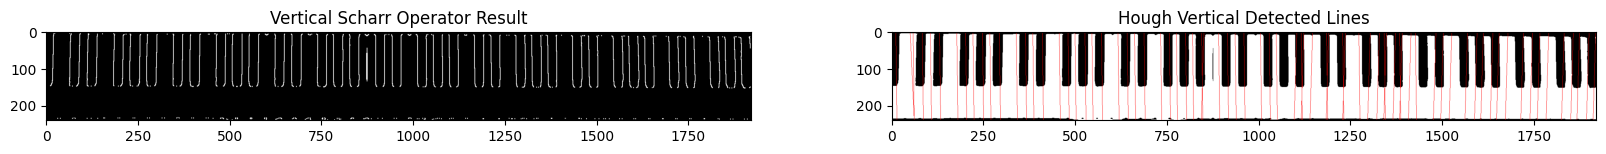

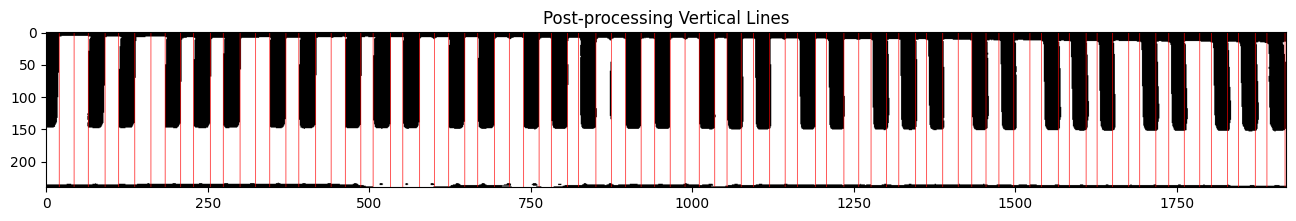

In [8]:
# Associate found edges with lines detected by Hough transform
def pairEdgeLines(edges, vert_lines):
    _, y_top, _, y_bottom = vert_lines[0]

    # Sort vertical lines from left to right
    sorted_vert_lines = sorted(vert_lines, key=lambda line: np.mean([line[0], line[2]]))
    idx_line = 0

    tolerance = 10 # pixels

    # Match Hough vertical lines to edges
    edge_to_lines_map = {}
    for edge in edges:
        x_edge, is_white_to_black = edge
        edge_to_lines_map[x_edge] = []

        # Find all lines close to edge
        while idx_line < len(sorted_vert_lines):
            x1, y1, x2, y2 = sorted_vert_lines[idx_line]
            mean_x = np.mean([x1, x2])

            # If line is within tolerance, consider it attached to edge
            if abs(x_edge - mean_x) < tolerance:
                edge_to_lines_map[x_edge].append((x1, y1, x2, y2))
                idx_line += 1
            # If too far forward, we must be at the next edge. Move on
            elif mean_x > x_edge:
                break
            # Handles line being too far behind
            else:
                idx_line += 1
        
        # Interpolated edge. Add a line 
        if not edge_to_lines_map[x_edge]:
            edge_to_lines_map[x_edge].append((x_edge, y_top, x_edge, y_bottom))

    # Take average just in case. Empirically 1-2 lines are matched to each edge
    for edge, lines in edge_to_lines_map.items():
        avg_x = 0
        for x1, _, x2, _ in lines:
            avg_x += np.mean([x1, x2])
        avg_x = int(avg_x / len(lines))

        edge_to_lines_map[edge] = (avg_x, y_top, avg_x, y_bottom)

    return [(edge, line) for edge, line in edge_to_lines_map.items()]

# Find vertical lines
sectioned_frame_binarized = frame_binarized[top[1]:bottom[1], :]

frame_scharr_vert = applyScharr(sectioned_frame_binarized, is_horiz=False)
hough_lines_vert = findHoughLines(frame_scharr_vert, theta_min=-np.pi/24, theta_max=np.pi/24, theta_step=np.pi/90)
hough_lines_vert = [(x1, 0, x2, frame_scharr_vert.shape[1]) for x1, _, x2, _ in hough_lines_vert]

# Match edges to lines
edge_line_pairs = pairEdgeLines(real_edges, hough_lines_vert)

# Scharr result
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.imshow(frame_scharr_vert, cmap="gray")
plt.title("Vertical Scharr Operator Result")

# Hough Lines result
frame_copy_1 = cv2.cvtColor(sectioned_frame_binarized, cv2.COLOR_GRAY2BGR)
for x1, y1, x2, y2 in hough_lines_vert:
    cv2.line(frame_copy_1, (x1, y1), (x2, y2), (255, 0, 0), thickness=1)
plt.subplot(1, 2, 2)
plt.imshow(frame_copy_1)
plt.title("Hough Vertical Detected Lines")

# Post-processing Vertical Lines
frame_copy_2 = cv2.cvtColor(sectioned_frame_binarized, cv2.COLOR_GRAY2BGR)
for edge, line in edge_line_pairs:
    x1, y1, x2, y2 = line
    cv2.line(frame_copy_2, (x1, y1), (x2, y2), (255, 0, 0), thickness=1)
plt.figure(figsize=(16, 12))
plt.imshow(frame_copy_2)
plt.title("Post-processing Vertical Lines")
plt.show()

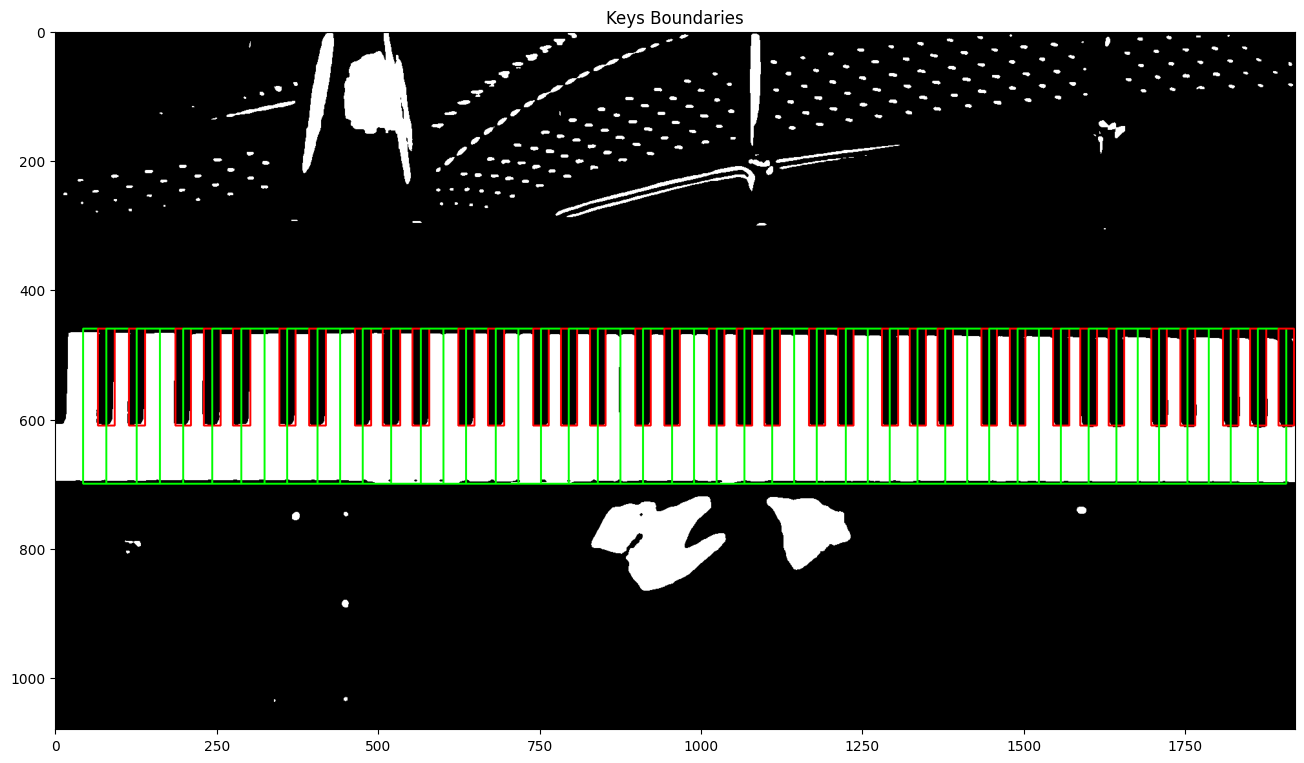

In [9]:
# Find bounding box of each key
def findKeyBoundaries(keys, edge_line_pairs, defining_lines):
    top, middle, bottom = defining_lines
    
    boundaries = []
    for i, key in enumerate(keys):
        next_key = keys[i + 1] if i + 1 < len(keys) else None
        prev_key = keys[i - 1] if i - 1 >= 0 else None
        key_boundaries = calculateKeyCorners(key, prev_key, next_key, top[1], middle[1], bottom[1])
        boundaries.append(key_boundaries)

    return [(key, bounds) for key, bounds in list(zip(keys, boundaries)) if bounds is not None]

def calculateKeyCorners(key, prev_key, next_key, top, middle, bottom):
    label, left_edge, right_edge = key
    left, _ = left_edge
    right, _ = right_edge

    # Case 1: Black key, always followed and preceded by white key
    if label == "B":
        top_left = (left, top)
        bottom_right = (right, middle)
        return (top_left, bottom_right)

    # Extract previous and next key if possible
    prev_label, prev_left_edge, _ = prev_key if prev_key else (None, None, None)
    next_label, _, next_right_edge = next_key if next_key else (None, None, None)
    prev_left, _ = prev_left_edge if prev_left_edge else (None, None)
    next_right, _ = next_right_edge if next_right_edge else (None, None)
    
    top_left, bottom_right = None, None

    # Case 2: White key followed by black key, preceded by white key (e.g. C)
    if label == "W" and next_label == "B" and prev_label == "W":
        top_left = (left, top)
        bottom_right = (int(np.mean([right, next_right])), bottom)
    # Case 3: White key followed by white key, preceded by black key (e.g. B)
    elif label == "W" and next_label == "W" and prev_label == "B":
        top_left = (int(np.mean([prev_left, left])), top)
        bottom_right = (right, bottom)
    # Case 4: White key followed by black key, preceded by black key (e.g. D)
    elif label == "W" and next_label == "B" and prev_label == "B":
        top_left = (int(np.mean([prev_left, left])), top)
        bottom_right = (int(np.mean([right, next_right])), bottom)
    
    return (top_left, bottom_right) if (top_left is not None and bottom_right is not None) else None

keys_with_boundaries = findKeyBoundaries(real_keys, edge_line_pairs, upscale_defining_lines)
frame_copy = cv2.cvtColor(frame_binarized, cv2.COLOR_GRAY2BGR)
for key, boundaries in keys_with_boundaries:
    color = (255, 0, 0) if key[0] == "B" else (0, 255, 0)
    top_left, bottom_right = boundaries
    cv2.rectangle(frame_copy, top_left, bottom_right, color, thickness=2)
plt.figure(figsize=(16, 12))
plt.imshow(frame_copy)
plt.title("Keys Boundaries")
plt.show()

In [10]:
# ----- 5. Key Identification -----

VALID_KEY_SEQUENCE = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
VALID_KEY_SEQUENCE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "Bb", "B"]

def nameKeys(keys):
    key_labels = [1 if label == "W" else 0 for (label, _, _), _ in keys]

    # Extend valid sequence to be longer than test sequence
    valid_sequence = VALID_KEY_SEQUENCE * (len(key_labels) // len(VALID_KEY_SEQUENCE) + 2) # 2 for rounding safety
    valid_sequence = valid_sequence[:len(key_labels) + 12]

    # Run cross-correlation
    correlation = np.correlate(key_labels, valid_sequence, mode="valid")

    # Find best alignment
    max_corr_idx = np.argmax(correlation)
    max_corr = correlation[max_corr_idx]

    # Validate sequence
    is_valid = (max_corr == sum(key_labels))
    if not is_valid:
        print("Failed to identify valid key sequence.")
        return None

    # Name keys
    start_key_idx = max_corr_idx % len(VALID_KEY_SEQUENCE)
    start_key_name = VALID_KEY_SEQUENCE_NAMES[start_key_idx]

    key_names = []
    cur_idx = VALID_KEY_SEQUENCE_NAMES.index(start_key_name)
    for key in key_labels:
        key_names.append(VALID_KEY_SEQUENCE_NAMES[cur_idx])
        cur_idx = (cur_idx + 1) % len(VALID_KEY_SEQUENCE)

    return [(name, key, boundaries) for (name, (key, boundaries)) in zip(key_names, keys)]


keys_with_names_and_boundaries = nameKeys(keys_with_boundaries)

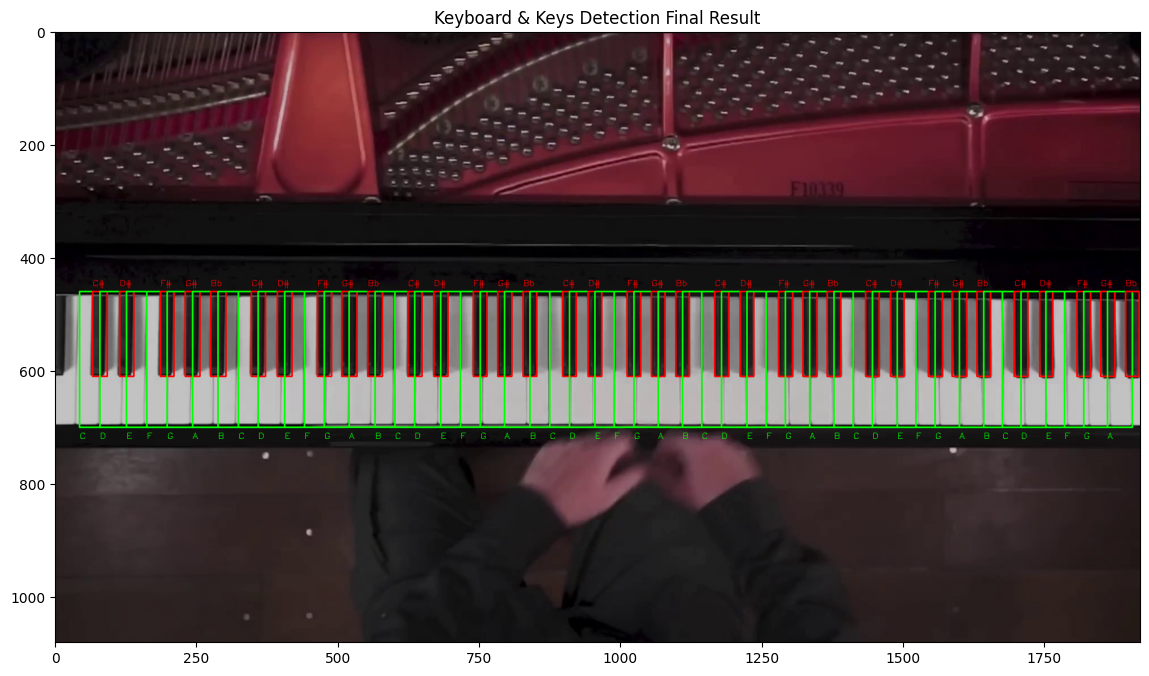

In [11]:
# Final result
frame_showcase = cv2.cvtColor(cv2.imread(FRAMES_DIR_PATH + TEST_FRAME), cv2.COLOR_BGR2RGB)
for name, key, boundaries in keys_with_names_and_boundaries:
    # Draw bounding rect
    color = (255, 0, 0) if key[0] == "B" else (0, 255, 0)
    top_left, bottom_right = boundaries
    cv2.rectangle(frame_showcase, top_left, bottom_right, color, thickness=2)

    # Add key name
    text_position = (top_left[0], bottom_right[1] + 20) if key[0] == "W" else (top_left[0], top_left[1] - 10)
    cv2.putText(frame_showcase, name, text_position, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=color, thickness=1)

plt.figure(figsize=(14, 10))
plt.imshow(frame_showcase)
plt.title("Keyboard & Keys Detection Final Result")
plt.show()

[(0, 45, 192, 45), (0, 61, 192, 61), (0, 70, 192, 70)]


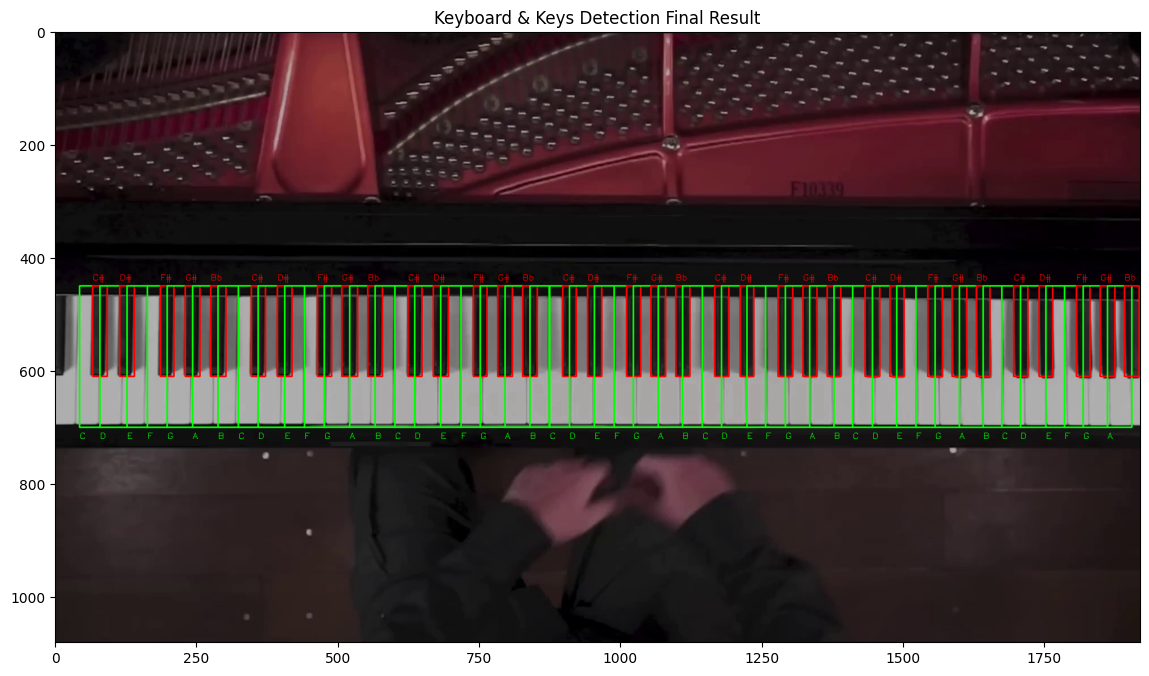

Finished iteration 1
[(0, 45, 192, 45), (0, 61, 192, 61), (0, 70, 192, 70)]


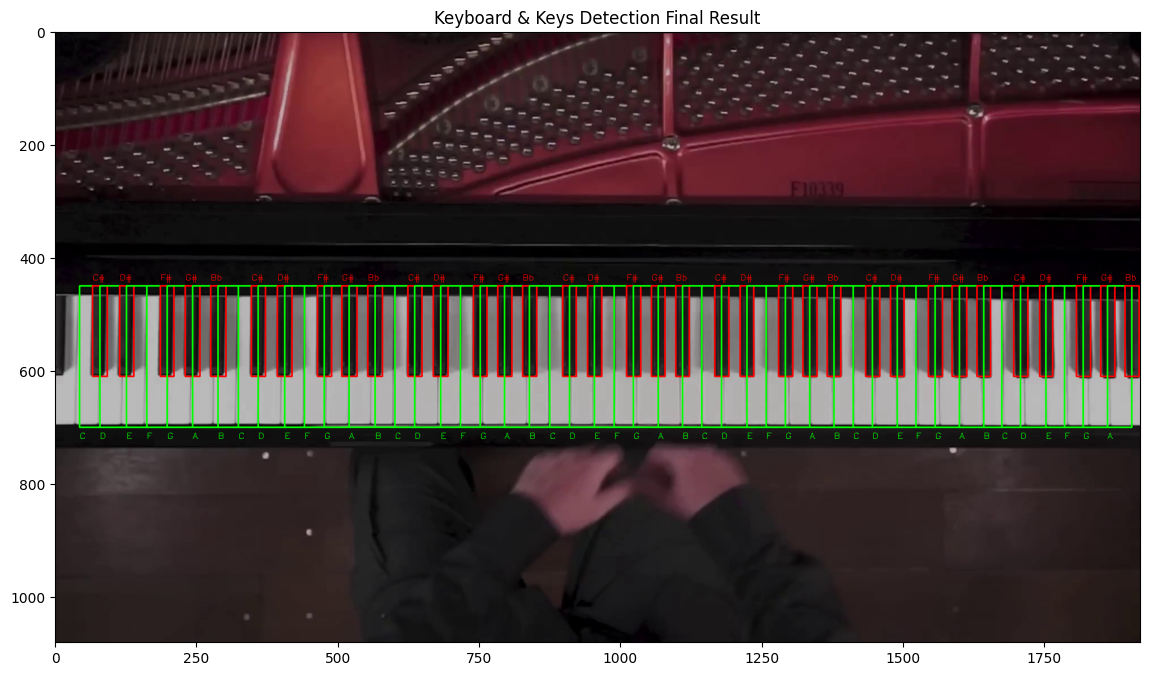

Finished iteration 2
[(0, 46, 192, 46), (0, 61, 192, 61), (0, 70, 192, 70)]


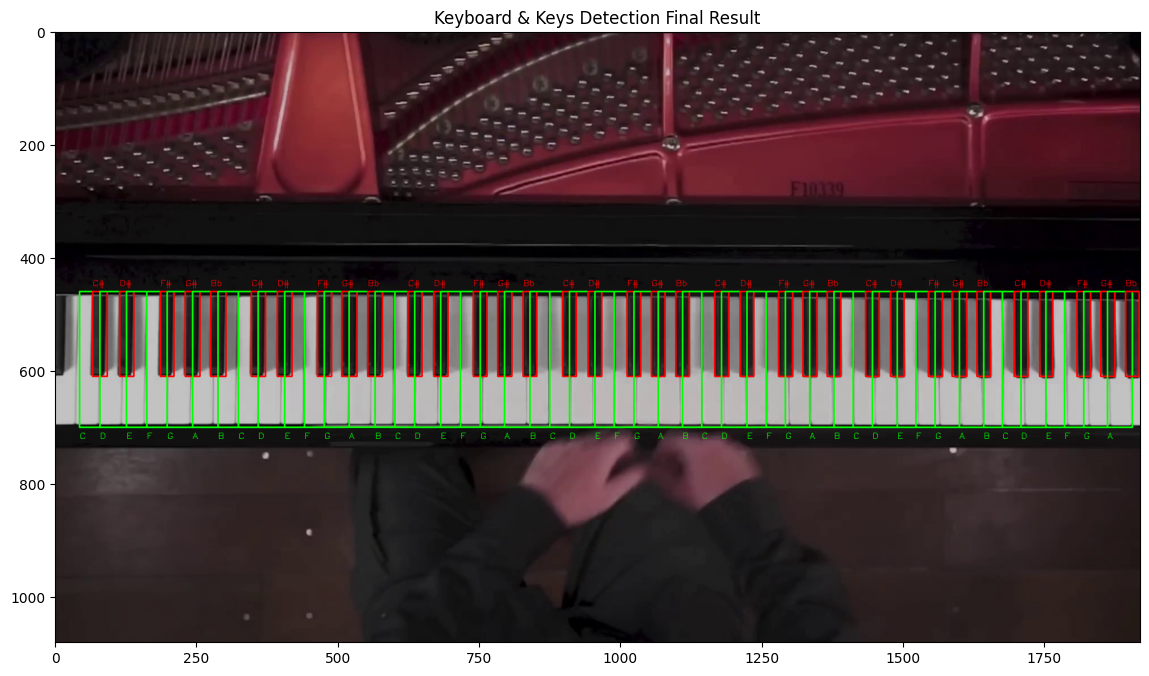

Finished iteration 3
[(0, 45, 192, 45), (0, 61, 192, 61), (0, 70, 192, 70)]


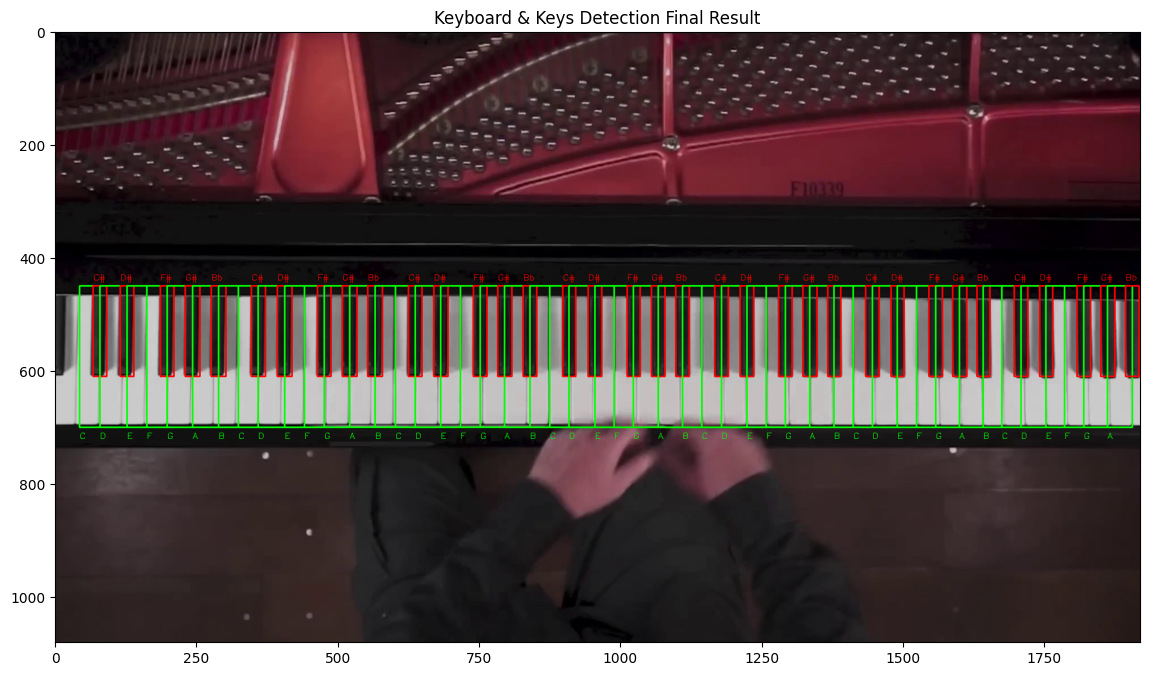

Finished iteration 4
[(0, 46, 192, 46), (0, 61, 192, 61), (0, 69, 192, 69)]


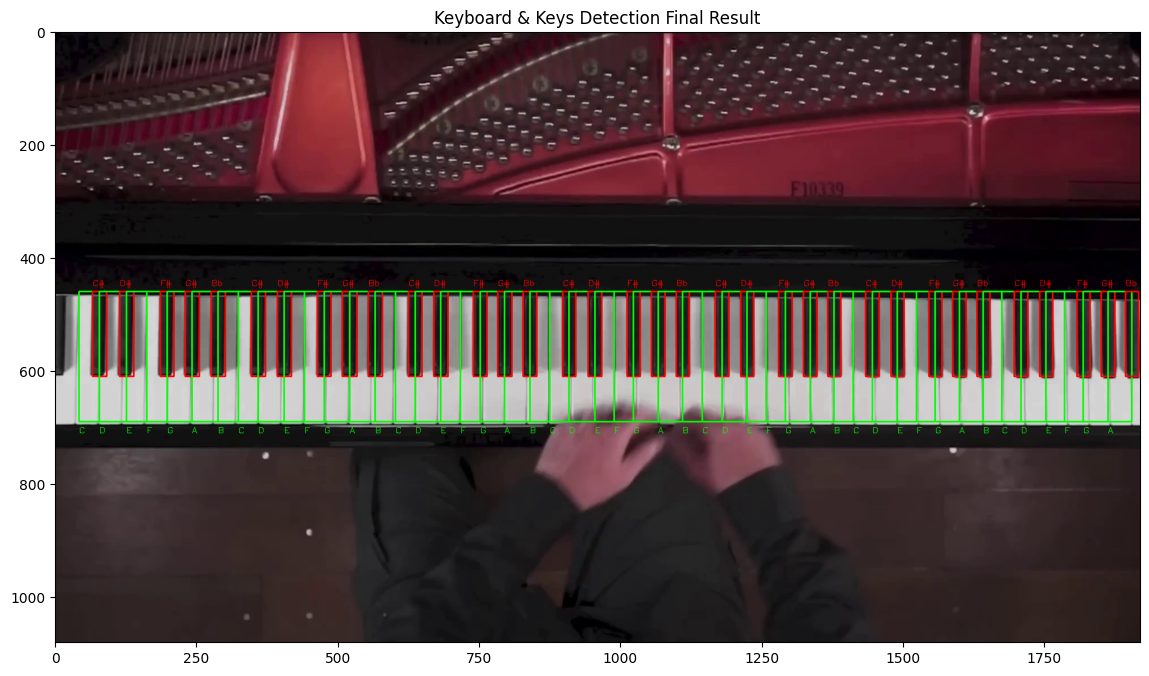

Finished iteration 5
[(0, 46, 192, 46), (0, 61, 192, 61), (0, 69, 192, 69)]


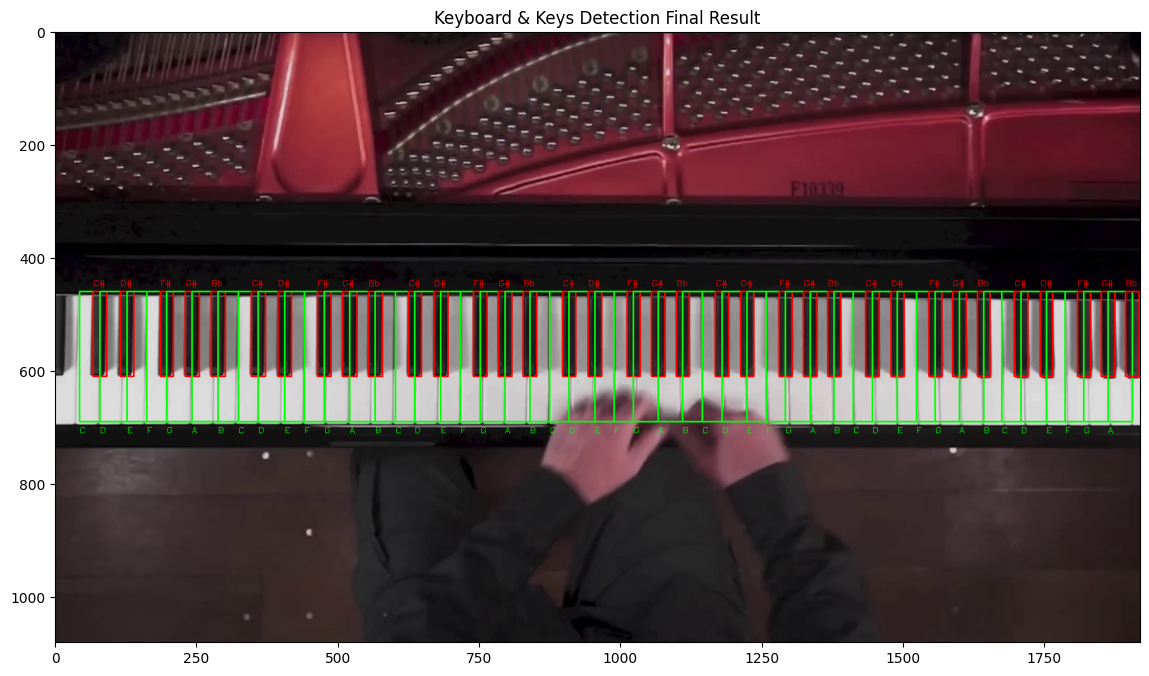

Finished iteration 6
[(0, 46, 192, 46), (0, 60, 192, 60), (0, 69, 192, 69)]


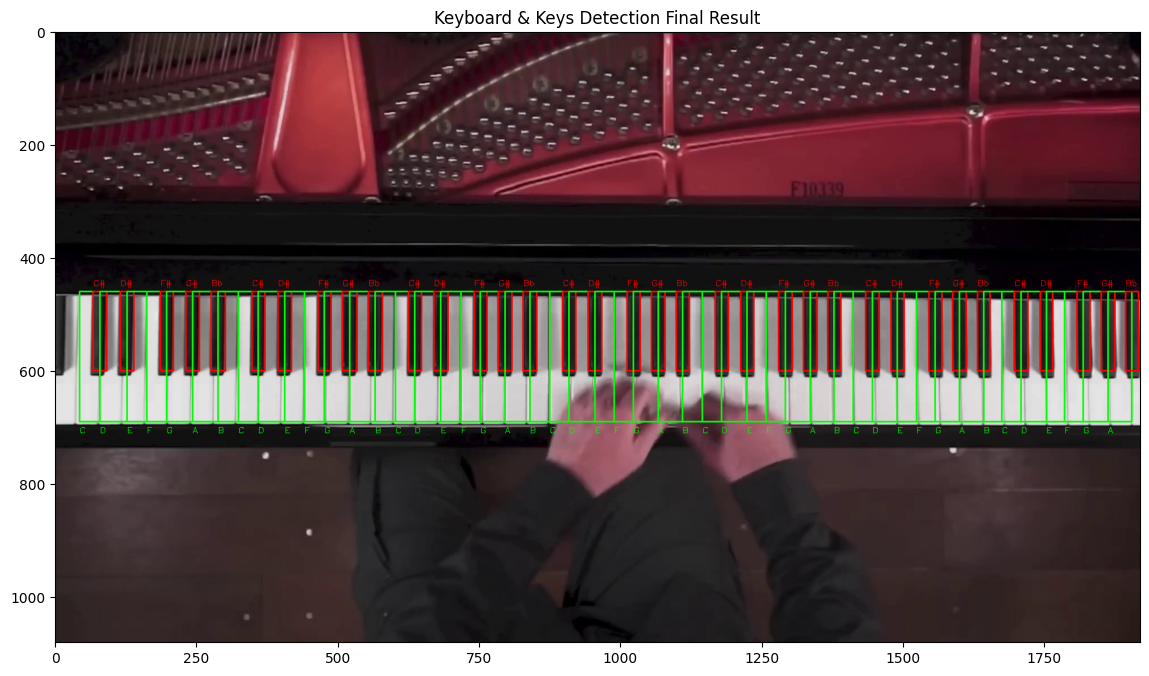

Finished iteration 7
[(0, 46, 192, 46), (0, 61, 192, 61), (0, 69, 192, 69)]


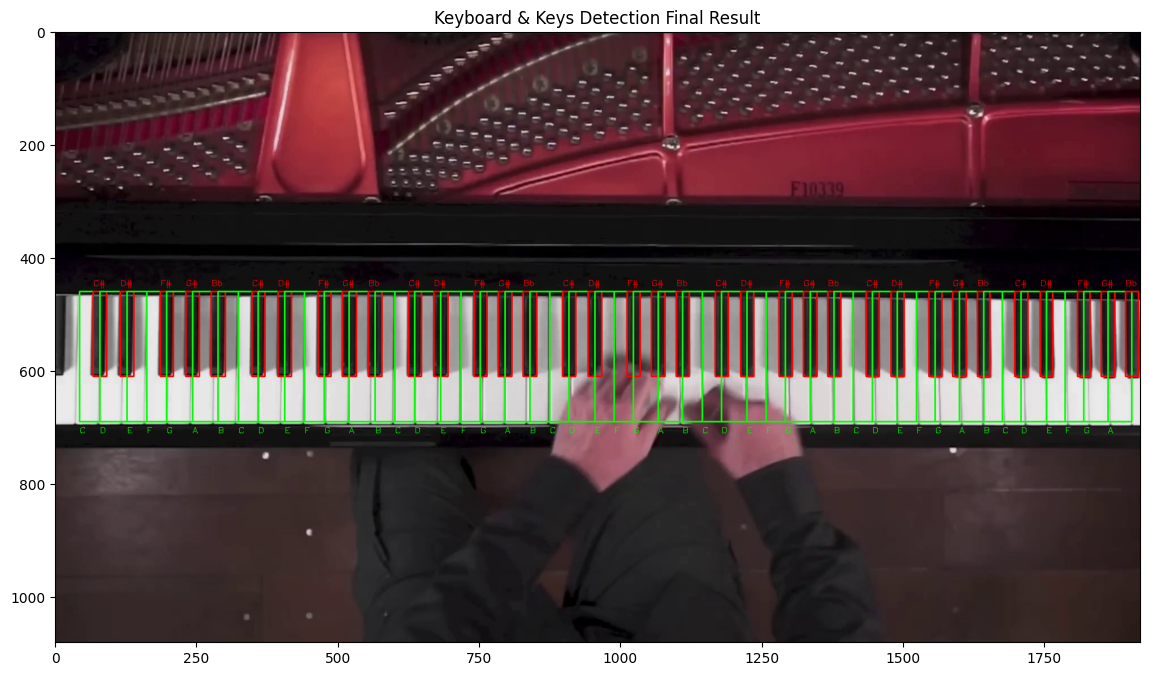

Finished iteration 8
[(0, 46, 192, 46), (0, 59, 192, 59), (0, 69, 192, 69)]


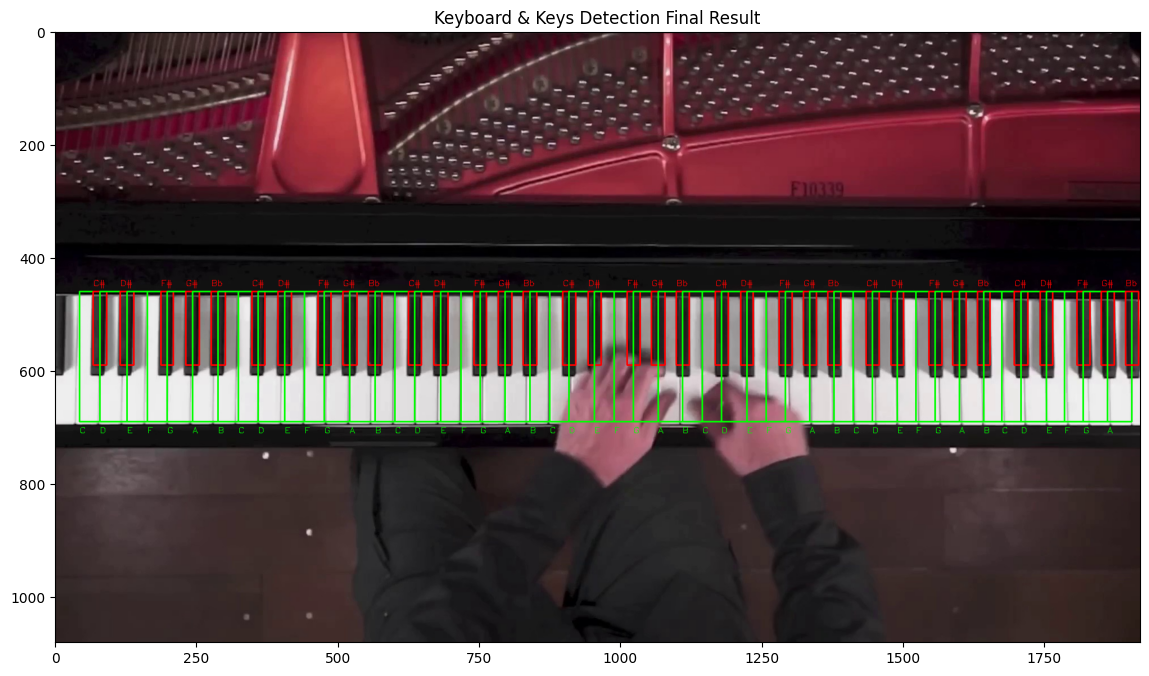

Finished iteration 9
[(0, 46, 192, 46), (0, 59, 192, 59), (0, 69, 192, 69)]


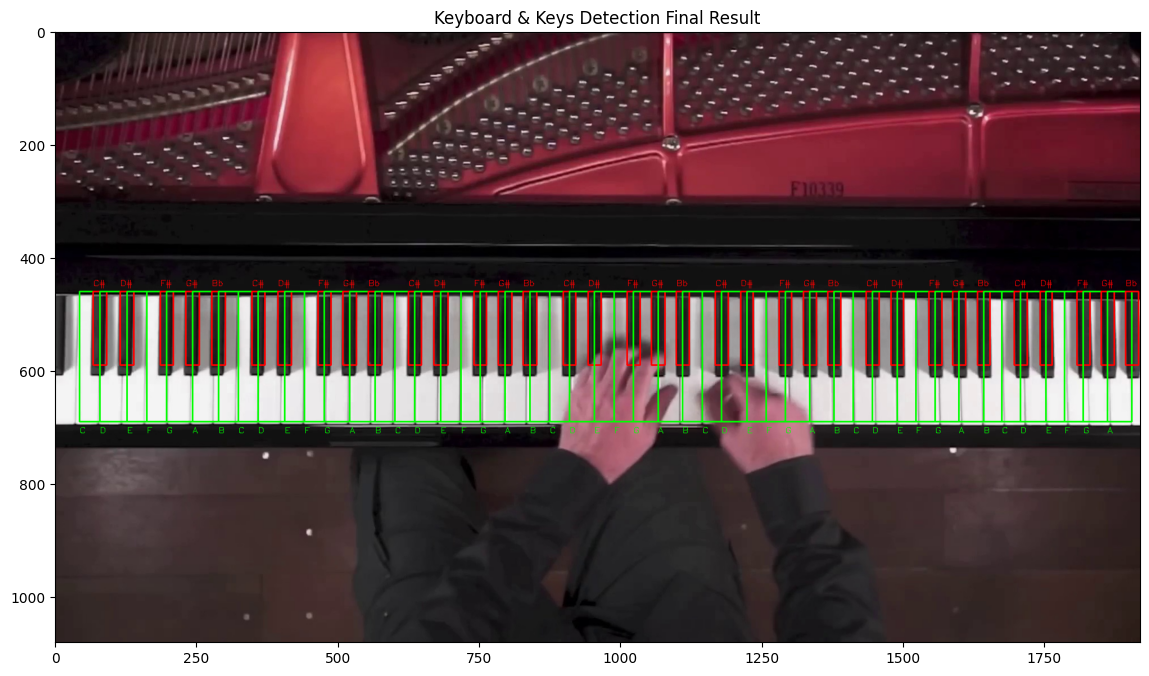

Finished iteration 10


In [18]:
# Final Routine

for i in range(1, 11):
    # Preprocessing
    frame_path = FRAMES_DIR_PATH + f"frame{i}.jpg"
    frame = cv2.cvtColor(cv2.imread(frame_path), cv2.COLOR_BGR2RGB)
    frame_preprocessed = preProcessFrame(frame_path)
    frame_thresholded = downsizeBinarizeFrame(frame_preprocessed, binary_threshold=100)

    # Keyboard Area Detection
    frame_scharr = applyScharr(frame_thresholded, True)
    hough_lines = findHoughLines(frame_scharr)
    defining_lines = averageLines(hough_lines, frame_scharr)
    print(defining_lines)
    frame_keyboard_area_final, defining_lines = rotateFrameMaybe(frame_scharr, defining_lines)

    # Keys Detection
    binary_threshold = 80
    _, frame_binarized = cv2.threshold(frame_preprocessed, binary_threshold, 255, cv2.THRESH_BINARY) # TODO
    upscale_defining_lines = [(x1, y1 * 10, x2, y2 * 10) for x1, y1, x2, y2 in defining_lines]

    potential_edges = detectKeyEdges(frame_binarized, upscale_defining_lines)
    keys = labelKeys(potential_edges)
    top, _, bottom = upscale_defining_lines
    real_keys, real_edges = interpolateWhiteKeys(keys)

    sectioned_frame_binarized = frame_binarized[top[1]:bottom[1], :]
    frame_scharr_vert = applyScharr(sectioned_frame_binarized, is_horiz=False)
    hough_lines_vert = findHoughLines(frame_scharr_vert, theta_min=-np.pi/24, theta_max=np.pi/24, theta_step=np.pi/90)
    hough_lines_vert = [(x1, 0, x2, frame_scharr_vert.shape[1]) for x1, _, x2, _ in hough_lines_vert]

    edge_line_pairs = pairEdgeLines(real_edges, hough_lines_vert)
    keys_with_boundaries = findKeyBoundaries(real_keys, edge_line_pairs, upscale_defining_lines)
    keys_with_names_and_boundaries = nameKeys(keys_with_boundaries)
    
    # Visualize Result
    for name, key, boundaries in keys_with_names_and_boundaries:
        # Draw bounding rect
        color = (255, 0, 0) if key[0] == "B" else (0, 255, 0)
        top_left, bottom_right = boundaries
        cv2.rectangle(frame, top_left, bottom_right, color, thickness=2)

        # Add key name
        text_position = (top_left[0], bottom_right[1] + 20) if key[0] == "W" else (top_left[0], top_left[1] - 10)
        cv2.putText(frame, name, text_position, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=color, thickness=1)
    plt.figure(figsize=(14, 10))
    plt.imshow(frame)
    plt.title("Keyboard & Keys Detection Final Result")
    plt.show()

    print(f"Finished iteration {i}")


Parameters to be tuned:
- Blurring with Gaussian
- Binarize threshold: This depends on the lighting of the image

Acknowledgements:
- Weights for the Scharr operator acquired from: https://www.geeksforgeeks.org/edge-detection-using-prewitt-scharr-and-sobel-operator/


Comparisons:
- NMS vs noNMS